In [1]:
import argparse
import json

import torch
# from peft import (
#     LoraConfig,
#     get_peft_model,
#     get_peft_model_state_dict,
#     prepare_model_for_kbit_training
# )
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    AutoModel
)
import sklearn
import pandas as pd
from sklearn.cluster import KMeans

from tqdm import tqdm

C:\Users\Egor\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pickle
# Загрузка списка embeds из файла
with open('research_Сlustering_v3_treding_topics_dataset\df_before_naming.pkl', 'rb') as f:
    df = pickle.load(f)

df = df.drop(columns="Cluster")
df

,Time,Source,Topic
0,2024-03-03,Twitter,Rashford
1,2024-03-03,Twitter,#sundayvibes
2,2024-03-03,Twitter,Xavier Worthy
3,2024-03-03,Twitter,Foden
4,2024-03-03,Twitter,#UFCVegas87
...,...,...,...
76135,2017-03-18,Google,Robert Osborne
76136,2017-03-18,Google,Alejandra Campoverdi
76137,2017-03-18,Google,Drake More Life
76138,2017-03-18,Google,Drake More Life Download


In [10]:
%pip install nltk
%pip install spacy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



You should consider upgrading via the 'c:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


---


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Объединение текстовых данных по датам и источникам
df_grouped = df.groupby('Time')['Topic'].apply(' '.join).reset_index()

# Создание объекта CountVectorizer для преобразования текста в матрицу признаков
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_grouped['Topic'])

# Обучение модели LDA
num_topics = 9  # Задайте количество тем
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# Вывод топовых слов для каждой темы
feature_names = vectorizer.get_feature_names_out()
num_top_words = 10
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Тема {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
    print()




Тема 0:
day john vs trump lakers league tom stock paul jones

Тема 1:
vs christmas day merry man lakers basketball michael stock paul

Тема 2:
day vs john paul chris new earthquake joe hunter michael

Тема 3:
vs football day cowboys happy new steelers mondaymotivation packers chiefs

Тема 4:
football vs state ohio texas day michigan barcelona penn liverpool

Тема 5:
day vs basketball john state happy tom warriors saturdaymorning 2017

Тема 6:
day basketball vs williams happy real madrid jones paul valentine

Тема 7:
vs day john chris man mexico david lakers real jones

Тема 8:
vs football man united day real madrid liverpool paul city

Тема 9:
vs day john basketball daily league quordle man stock barcelona



## Preprocessing Topics

### Remove stopwords

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from copy import deepcopy
import nltk
nltk.download('stopwords')

import nltk
nltk.download('punkt')

# Создание копии датасета
df_copy = deepcopy(df)

# Предобработка текста
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Приведение к нижнему регистру и токенизация
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]  # Удаление стоп-слов и пунктуации
    return ' '.join(tokens)

df_copy['Topic'] = df_copy['Topic'].apply(preprocess_text)

# Создание матрицы признаков
vectorizer = CountVectorizer(analyzer="word", min_df=10, ngram_range=(2-3), stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df_copy['Topic'])

# Обучение модели LDA
num_topics = 10  # Задайте количество тем
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# Вывод топовых слов для каждой темы
feature_names = vectorizer.get_feature_names_out()
num_top_words = 10
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Тема {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
    print()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Тема 0:
day mondaymotivation national league sundaymorning champions 2018 2019 sundayvibes clippers

Тема 1:
warriors jones black williams thursdaythoughts steelers packers tuesdaythoughts vs green

Тема 2:
vs real madrid celtics aaron johnson nfl anthony scott david

Тема 3:
football trump state basketball joe barcelona vs jackson michael ufc

Тема 4:
vs happy chiefs 49ers mike biden raiders school caturday mondaythoughts

Тема 5:
vs man united city chelsea kevin football earthquake smith new

Тема 6:
liverpool arsenal vs cup wednesdaythought wilson ravens russell eric jordan

Тема 7:
paul chris taylor cowboys wednesdaywisdom eagles robert swift apple saints

Тема 8:
vs lakers stock tom texas josh west state football ohio

Тема 9:
john daily quordle saturdaymorning michigan fridayfeeling big game kelly ben



### Add lemanitisation

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from copy import deepcopy
import nltk
import spacy

# Загрузка стоп-слов и пунктуации
nltk.download('stopwords')
nltk.download('punkt')

# Загрузка модели spaCy для английского языка
nlp = spacy.load("en_core_web_sm")

# Создание копии датасета
df_copy = deepcopy(df)

# Предобработка текста с использованием spaCy
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    doc = nlp(text.lower())  # Приведение к нижнему регистру и токенизация с помощью spaCy
    tokens = [token.lemma_ for token in doc if len(token.text) >= 3 and token.text not in stop_words and token.text not in string.punctuation]  # Лемматизация слов и удаление стоп-слов, пунктуации и слов короче трех символов
    return ' '.join(tokens)

df_copy['Topic'] = df_copy['Topic'].apply(preprocess_text)

# Создание матрицы признаков
vectorizer = CountVectorizer(analyzer="word", min_df=10, ngram_range=(2,3), stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df_copy['Topic'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
vectorizer.get_feature_names_out().tolist()

['25th amendment',
 '4th july',
 'aaron carter',
 'aaron donald',
 'aaron hernandez',
 'aaron judge',
 'aaron rodger',
 'addison rae',
 'adrian peterson',
 'alabama football',
 'albert pujol',
 'alec baldwin',
 'alex jones',
 'alex smith',
 'alex trebek',
 'aly raisman',
 'amanda byne',
 'amari cooper',
 'amazon prime',
 'amazon prime day',
 'amazon stock',
 'amber alert',
 'amber hear',
 'amc stock',
 'amd stock',
 'american flag',
 'american horror',
 'american horror story',
 'american idol',
 'amy schumer',
 'andrew gillum',
 'andrew luck',
 'andrew tate',
 'andrew yang',
 'andy cohen',
 'animal crossing',
 'ann coulter',
 'anthony davis',
 'anthony edwards',
 'antonio brown',
 'apple stock',
 'april fool',
 'ar 15',
 'aretha franklin',
 'ariana grande',
 'arkansas football',
 'armie hammer',
 'arnold schwarzenegger',
 'arsenal man',
 'asap rocky',
 'ash wednesday',
 'aston villa',
 'atlanta falcon',
 'auburn basketball',
 'auburn football',
 'austin river',
 'avery bradley',
 'awa

In [ ]:
df_copy

,Time,Source,Topic,Cluster
0,2024-03-03,Twitter,rashford,5
1,2024-03-03,Twitter,sundayvibe,7
2,2024-03-03,Twitter,xavier worthy,2
3,2024-03-03,Twitter,foden,5
4,2024-03-03,Twitter,ufcvegas87,1
...,...,...,...,...
76135,2017-03-18,Google,robert osborne,2
76136,2017-03-18,Google,alejandra campoverdi,5
76137,2017-03-18,Google,drake life,3
76138,2017-03-18,Google,drake life download,3


In [ ]:
df_copy.to_csv('preprocessed_file.csv', index=False)

In [ ]:
import pickle

# Сохранение объекта векторайзера
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Сохранение матрицы признаков
with open('feature_matrix.pkl', 'wb') as f:
    pickle.dump(X, f)

In [ ]:
# # Загрузка списка embeds из файла
# with open('embeds.pkl', 'rb') as f:
#     embeds = pickle.load(f)

In [ ]:
# Обучение модели LDA
num_topics = 10  # Задайте количество тем
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# Вывод топовых слов для каждой темы
feature_names = vectorizer.get_feature_names_out()
num_top_words = 10
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Тема {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
    print()

Тема 0:
taylor swift ohio state new year world cup kylie jenner college football north korea notre dame world series happy new

Тема 1:
elon musk harry style duke basketball nicki minaj travis scott nebraska football simone bile michael jackson bitcoin price aston villa

Тема 2:
daily quordle man city premier league billie eilish dolly parton father day bad bunny detroit lion inter miami meghan markle

Тема 3:
man unite europa league tom brady mega million star war nick cannon kevin durant alabama football aaron judge cinco mayo

Тема 4:
real madrid happy birthday chicago bear paul george john mccain cam newton james harden veteran day miley cyrus merry christmas

Тема 5:
aaron rodger antonio brown red sox kanye west lebron james michigan football liz cheney ariana grande jeff bezos black friday

Тема 6:
manchester united supreme court serena williams miami heat pete davidson memorial day miami dolphin cleveland brown texas football pittsburgh penguin

Тема 7:
champions league state fo

### Visualisation

In [ ]:
!pip install pyLDAvis

how to fix errors - pandax 1.5.3
- https://stackoverflow.com/questions/76117613/brokenprocesspool-a-task-has-failed-to-un-serialize-error-when-running-pylda
- common errors https://www.perplexity.ai/search/import-pyLDAvis-import-7Ufatx5bSIKY0gpqZ.eXwg

In [ ]:
!pip install pandas==1.5.3

In [ ]:
import pyLDAvis
import pyLDAvis.lda_model

# Визуализация с помощью pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda_model, X, vectorizer, mds='tsne')
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


### Quality

In [ ]:

# Оценка перплексии. Чем ниже, тем лучше
perplexity = lda_model.perplexity(X)
print("Перплексия модели LDA:", perplexity)

likelihood = lda_model.score(X)
print("Likelihood модели LDA:", perplexity)

# Перплексия модели LDA: 818.693408373049
# Likelihood модели LDA: 818.693408373049


Тема называется когерентной (согласованной), если её топ-N слова встречаются вместе чаще, чем можно было бы ожидать от случайного распределения (топ-N наиболее вероятных слов для конкретной темы). Высококогерентная тема содержит семантически связанные между собой слова. Метрика коррелирует с
экспертными оценками.

In [ ]:
def get_coherence_mean(model, texts, n_top_words = 20):
    topics = model.components_

    # Преобразование текста в список токенов
    texts = [word_tokenize(text) for text in texts]

    # Создание словаря с использованием Gensim
    dictionary = corpora.Dictionary(texts)

    corpus = [dictionary.doc2bow(text) for text in texts]

    feature_names = [dictionary[i] for i in range(len(dictionary))]

    top_words = []
    for topic in topics:
        top_words.append(
            [feature_names[i] for i in topic.argsort()[:-n_top_words - 1: -1]]
        )

    coherence_model = CoherenceModel(topics=top_words,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')

    coherence = coherence_model.get_coherence()
    return coherence

get_coherence_mean(lda_model, df_copy['Topic'].tolist())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.6998687353874181

In [ ]:
test_lst=df_copy['Topic'].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
test_lst

### Selection of number of topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/8 [00:00<?, ?it/s]

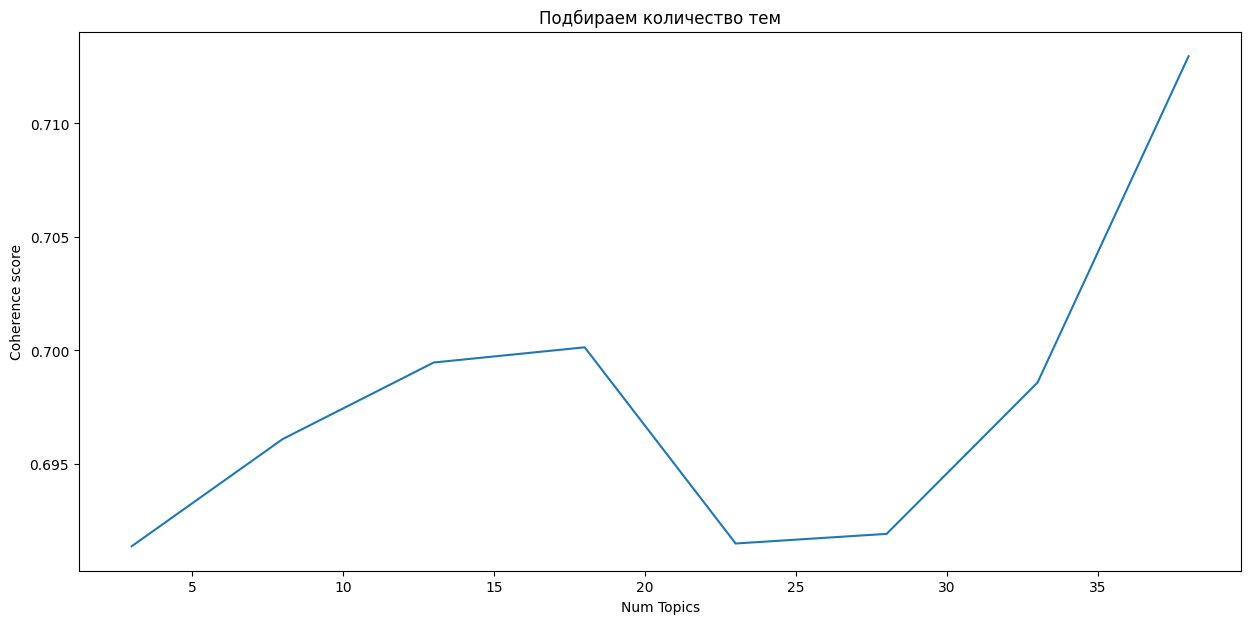

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from tqdm.notebook import tqdm

def compute_coherence_values(vec_train_text, test_text, min_topic=2, max_topic=40, step=5):
    """Вычисление оценок в зависимости от количества тематик"""
    coherence_values = []
    model_list = []

    for num_topics in tqdm(range(min_topic, max_topic, step)):
        model = LatentDirichletAllocation(
            n_components=num_topics,
            learning_method='online',
            random_state=42,
            n_jobs=-1,
            max_iter=10
        )
        model.fit(vec_train_text)
        model_list.append(model)
        coherence_values.append(get_coherence_mean(model, test_text))

    return model_list, coherence_values

min_topic = 3
max_topic = 40
step = 5

model_list, coherence_values = compute_coherence_values(
    vec_train_text=X,
    test_text=test_lst,
    min_topic=min_topic,
    max_topic=max_topic,
    step=step
)

x = range(min_topic, max_topic, step)
plt.figure(figsize=(15, 7))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Подбираем количество тем")
plt.show()


test_vec_ben = X
vector_ben = vec

In [ ]:
for n_topics, coherence in zip(x, coherence_values):
    print(f"Количество тем = {n_topics}, Когерентность = {coherence:.3f}")

# Модель латентного размещения Дирихле
# lda_model_ben = LatentDirichletAllocation(
#     n_components=35,
#     max_iter=10,
#     learning_method='online',
#     random_state=42,
#     n_jobs=-1
# )
lda_model_ben = LatentDirichletAllocation(n_components=18, random_state=42)
lda_model_ben.fit(X)
print(lda_model_ben)

get_coherence_mean(lda_model_ben, test_lst)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Количество тем = 3, Когерентность = 0.691
Количество тем = 8, Когерентность = 0.696
Количество тем = 13, Когерентность = 0.699
Количество тем = 18, Когерентность = 0.700
Количество тем = 23, Когерентность = 0.691
Количество тем = 28, Когерентность = 0.692
Количество тем = 33, Когерентность = 0.699
Количество тем = 38, Когерентность = 0.713
LatentDirichletAllocation(n_components=18, random_state=42)


AttributeError: module 'pyLDAvis' has no attribute 'sklearn'

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda_model_ben, X, vectorizer, mds='tsne')
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


#### Lost tries

In [ ]:
!pip install gensim

In [ ]:
import pyLDAvis.gensim
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models


# Преобразование матрицы признаков в формат Gensim
corpus = gensim.matutils.Sparse2Corpus(X.T)

# Создание словаря
id2word = {value: key for key, value in vectorizer.vocabulary_.items()}
gensim_dict = corpora.Dictionary.from_corpus(corpus, id2word=id2word)

# Обучение модели LDA с помощью Gensim
lda_model_gensim = LdaModel(corpus=corpus, id2word=gensim_dict, num_topics=num_topics, random_state=42)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Преобразование текста в список токенов
tokenized_text = [word_tokenize(text) for text in df_copy['Topic']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from gensim.models import CoherenceModel

# Создание модели когерентности
coherence_model_lda = CoherenceModel(model=lda_model_gensim, texts=tokenized_text, dictionary=gensim_dict, coherence='c_v')

# Получение значения когерентности
coherence_lda = coherence_model_lda.get_coherence()

print("Когерентность модели LDA:", coherence_lda)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Когерентность модели LDA: nan


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

# Визуализация с помощью pyLDAvis
vis = pyLDAvis.gensim_models.prepare(lda_model_gensim, corpus, gensim_dict)
pyLDAvis.display(vis)
